# Using Predictions to Make More Predictions

#### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd
# Data manipulation
import datetime
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Scalation
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

# Warnings
import warnings

In [2]:
from tensorflow.keras.optimizers.legacy import Adam

In [3]:
warnings.filterwarnings('ignore')

##### Visualization Set Up

In [4]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = True

In [5]:
print(tf.__version__)

2.15.0


In [6]:
# Numerical & Tensorflow Setting Seeds
tf.random.set_seed(42)
np.random.seed(42)

##### Loading Data

In [7]:
train_df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/train.csv', index_col=0)
val_df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/val.csv', index_col=0)
test_df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


##### Setting Data Window Function

In [8]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

##### Setting Compile & Fit Function

In [9]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [10]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

### AutoRegressive Long Short-Term Memory (ARLSTM)

In [11]:
# Values obtained from chapter 16

ms_mae_val = [0.352, 0.347, 0.088, 0.078, 0.070, 0.078, 0.069]
ms_mae_test = [0.347, 0.341, 0.076, 0.064, 0.058, 0.063, 0.055]

In [12]:
# Data Windowing
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

##### Setting an Autoregressive Class:

In [13]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

##### Running up The AutoRegressive LSTM Model

In [14]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

# Model Training
history = compile_and_fit(AR_LSTM, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
ms_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 2s 4ms/step - loss: 0.0428 - mean_absolute_error: 0.1520 - val_loss: 0.0194 - val_mean_absolute_error: 0.1000
Epoch 2/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0160 - mean_absolute_error: 0.0898 - val_loss: 0.0168 - val_mean_absolute_error: 0.0902
Epoch 3/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0149 - mean_absolute_error: 0.0849 - val_loss: 0.0169 - val_mean_absolute_error: 0.0924
Epoch 4/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0145 - mean_absolute_error: 0.0831 - val_loss: 0.0168 - val_mean_absolute_error: 0.0918
Epoch 5/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0143 - mean_absolute_error: 0.0825 - val_loss: 0.0158 - val_mean_absolute_error: 0.0874
Epoch 6/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0138 - mean_absolute_error: 0.0807 - val_loss: 0.0164 - val_mean_absolute_error: 0.0896
Epoch 7/50
383/3

##### Checking Model Performance

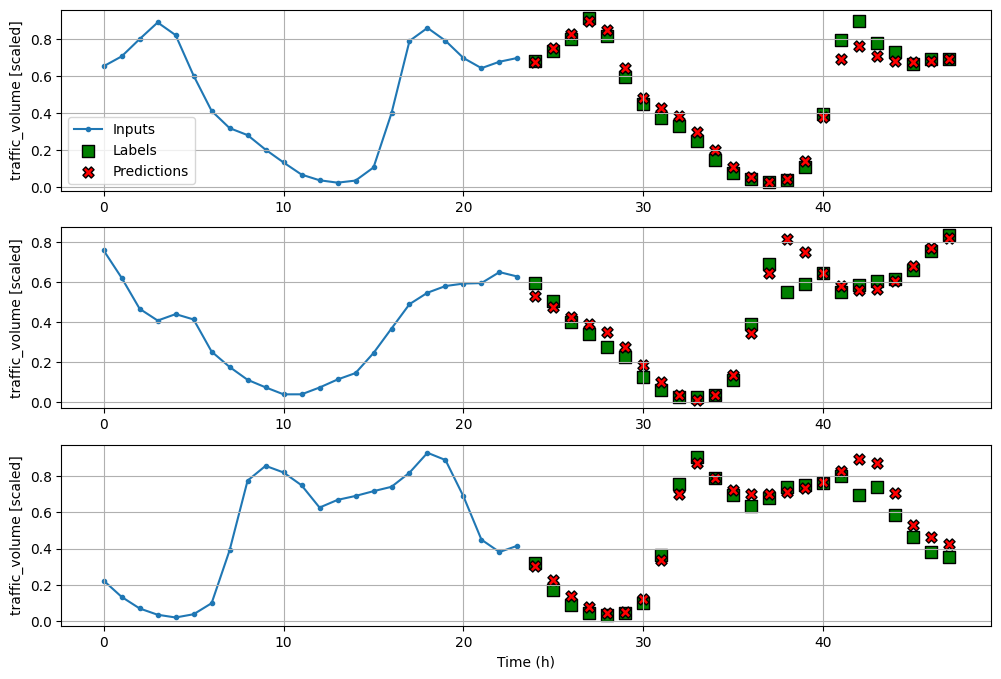

In [16]:
multi_window.plot(AR_LSTM)

##### Contrasting Model Metrics

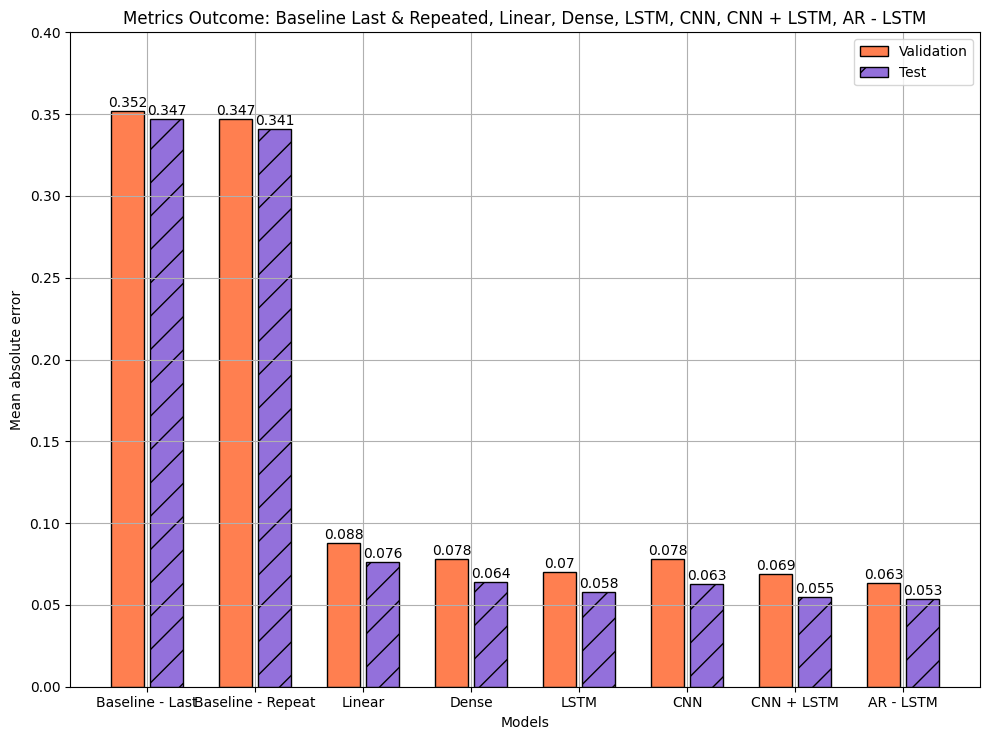

In [17]:
ms_mae_val.append(ms_val_performance['AR - LSTM'][1])
ms_mae_test.append(ms_performance['AR - LSTM'][1])

x = np.arange(8)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM', 'AR - LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.18, ms_mae_val, width=0.3, color='coral', edgecolor='black', label='Validation')
ax.bar(x + 0.18, ms_mae_test, width=0.3, color='mediumpurple', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.title('Metrics Outcome: Baseline Last & Repeated, Linear, Dense, LSTM, CNN, CNN + LSTM, AR - LSTM')
plt.tight_layout()
plt.show()